In [1]:
# Forked From - https://www.kaggle.com/samratp/avito-lightgbm-with-ridge-feature-v-3-0-0-2219
# Added aggregated features: https://link.zhihu.com/?target=https%3A//www.kaggle.com/bminixhofer/aggregated-features-lightgbm
# Added image features blurriness, whiteness, dullness: https://www.kaggle.com/shivamb/ideas-for-image-features-and-image-quality
# Added image feature key point: https://www.kaggle.com/c/avito-demand-prediction/discussion/59414
# Added imputed image_top_1: https://www.kaggle.com/christofhenkel/text2image-top-1/notebook


import time
notebookstart= time.time()

import numpy as np
import pandas as pd
import os
import gc
import random
random.seed(2018)

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline 

/home/liyinxiao1227/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

NFOLDS = 5
SEED = 2018
VALID = False
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"
    
    
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [3]:
print("\nData Load Stage")
training = pd.read_csv('train_processed_imagetop_kp.csv', index_col = "item_id", parse_dates = ["activation_date"])

# training = training.iloc[0:100,:]
traindex = training.index

testing = pd.read_csv('test_processed_imagetop_kp.csv', index_col = "item_id", parse_dates = ["activation_date"])
# testing = testing.iloc[0:100,:]
testdex = testing.index


# training.drop("dullness",axis=1, inplace=True)
# testing.drop("dullness",axis=1, inplace=True)


ntrain = training.shape[0]
ntest = testing.shape[0]



Data Load Stage


In [4]:
training

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,...,image,deal_probability,image_blurrness_score,dullness,avg_days_up_user,avg_times_up_user,n_user_items,image_top_1,whiteness,kp
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",...,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,0.12789,401.946496,0.000,8.000000,2.000000,2,1008.0,1.965,3331.0
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",...,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,0.00000,1021.622874,6.335,NaN,NaN,1,692.0,0.000,3361.0
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",...,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,0.43177,493.959775,0.000,4.428571,1.142857,9,3032.0,72.020,432.0
02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,...,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,0.80323,377.384977,0.000,16.714286,2.642857,32,796.0,94.325,622.0
7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,...,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,0.20797,558.971654,7.715,NaN,NaN,1,2264.0,1.320,5812.0
51e0962387f7,bbfad0b1ad0a,Татарстан,Чистополь,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Авто люлька,В хорошем состоянии,...,eb6ad1231c59d3dc7e4020e724ffe8e4d302023ddcbb99...,0.80323,759.280719,5.965,4.000000,1.000000,2,796.0,5.025,2534.0
c4f260a2b48a,08f469d2e6f7,Нижегородская область,Нижний Новгород,Для дома и дачи,Ремонт и строительство,Сантехника и сауна,NaN,NaN,Водонагреватель 100 литров нержавейка плоский,Электро водонагреватель накопительный на 100 л...,...,0330f6ac561f5db1fa8226dd5e7e127b5671d44d075a98...,0.00000,220.479333,41.200,7.333333,1.222222,11,2823.0,13.960,1704.0
6b71309d6a8a,fef86baa002c,Пермский край,Пермь,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Джинсы,26,Бойфренды colins,Бойфренды в хорошем состоянии.,...,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...,0.80323,2343.397682,0.000,11.916667,1.666667,23,567.0,0.000,11582.0
c5b969cb63a2,055825270190,Оренбургская область,Оренбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,> 50 (XXL),Платье,54 раз мер очень удобное,...,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...,0.00000,890.431199,0.000,13.517241,1.896552,38,415.0,0.000,4275.0


In [5]:
testing

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,...,user_type,image,image_blurrness_score,dullness,avg_days_up_user,avg_times_up_user,n_user_items,image_top_1,whiteness,kp
item_id,,,,,,,,,,,,,,,,,,,,,
6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,...,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,322.014715,25.640,7.500000,1.500000,6,2020.0,23.380,1680.0
65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",...,Private,NaN,-1.000000,-1.000,NaN,NaN,1,2325.0,NaN,NaN
8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,...,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,759.823084,93.715,6.000000,1.000000,4,2960.0,6.285,2734.0
8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",...,Private,NaN,-1.000000,-1.000,15.066667,2.666667,19,1817.0,NaN,NaN
8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,...,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,351.179388,53.820,6.500000,1.000000,5,1002.0,0.000,3503.0
c63dbd6c657f,c2a632af2602,Ростовская область,Ростов-на-Дону,Для дома и дачи,Ремонт и строительство,Окна и балконы,NaN,NaN,Стекла для пластиковых окон,Продаю стеклопакеты новые:/\n1. 1322х652х24 /\...,...,Private,7acdde494d48f4e46c8be158d64ad73a61d153b825c378...,214.179187,0.000,3.500000,1.000000,3,1409.0,0.000,1068.0
6d1a410df86e,b239811ad530,Оренбургская область,Оренбург,Бытовая электроника,Ноутбуки,NaN,NaN,NaN,Ноутбук Lenovo Ideapad 300-15Ibr арт.14899,Описание: /\nНоутбук Lenovo IdeaPad 300-15IBR ...,...,Shop,f52abf9f68eca4aac35ed2b67bf093095950c417c080dd...,977.643564,0.000,8.054113,1.108225,4074,2961.0,0.000,4012.0
e8d3e7922b80,d85fa02e6341,Калининградская область,Калининград,Бытовая электроника,Телефоны,Аксессуары,Чехлы и плёнки,NaN,Nillkin Phenom для Apple iPhone,Для iPhone 7 (черный)/\n /\nПродаются от магаз...,...,Shop,2e2b5526345f5d66571615dd0fdc984f765a336ec6df3d...,1886.664190,1.455,15.911255,2.248918,505,2909.0,62.860,2096.0
2bc1ab208462,ae6586719bec,Новосибирская область,Новосибирск,Бытовая электроника,Товары для компьютера,Флэшки и карты памяти,NaN,NaN,Флешка USB 32Gb smartbuy,новые/\n /\nесть синие и оранжевые/\n /\nSmart...,...,Company,8aa1dfcbdc489750eb965e43ff545505f2c845990d73f9...,1436.228039,0.000,11.569848,1.374136,1947,2815.0,96.610,1297.0


In [6]:
kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)
kf

sklearn.cross_validation.KFold(n=1503424, n_folds=5, shuffle=True, random_state=2018)

In [7]:

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))


print("Feature Engineering")

df['city'] = df['region'] + "_" + df['city'] # # City names are duplicated across region, HT: Branden Murray 

df["price"] = np.log(df["price"]+0.001)
# df["price"].fillna(df.price.mean(),inplace=True)  # i believe not imputing price would be better for lgb
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
#df["Weekd of Year"] = df['activation_date'].dt.week
#df["Day of Month"] = df['activation_date'].dt.day

# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date","image"],axis=1,inplace=True)

print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str))

Train shape: 1503424 Rows, 23 Columns
Test shape: 508438 Rows, 23 Columns
Combine Train and Test

All Data shape: 2011862 Rows, 23 Columns
Feature Engineering

Create Time Variables

Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']


In [8]:

print("\nText Features")

# Feature Engineering 
# Meta Text Features
textfeats = ["description", "title"]
df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation])) # number of punctuations 


Text Features


In [9]:
df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

In [10]:

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    df[cols + '_num_letters'] = df[cols].apply(lambda comment: len(comment)) # Count number of Letters
    df[cols + '_num_alphabets'] = df[cols].apply(lambda comment: (comment.count(r'[a-zA-Z]'))) # Count number of Alphabets
    df[cols + '_num_alphanumeric'] = df[cols].apply(lambda comment: (comment.count(r'[A-Za-z0-9]'))) # Count number of AlphaNumeric
    df[cols + '_num_digits'] = df[cols].apply(lambda comment: (comment.count('[0-9]'))) # Count number of Digits
    

In [11]:

# Extra Feature Engineering
df['title_desc_len_ratio'] = df['title_num_letters']/df['description_num_letters']


In [12]:


print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


def get_col(col_name): return lambda x: x[col_name]


##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('title',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])
    
start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))


[TF-IDF] Term Frequency Inverse Document Frequency Stage
Vectorization Runtime: 12.50 Minutes



Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.23033890453576603
Modeling Stage
1503424 Rows and 1430797 Cols
508438 Rows and 1430797 Cols
Feature Names Length:  1430797

Modeling Stage
Light Gradient Boosting Regressor


/home/liyinxiao1227/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Model Evaluation Stage


/home/liyinxiao1227/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


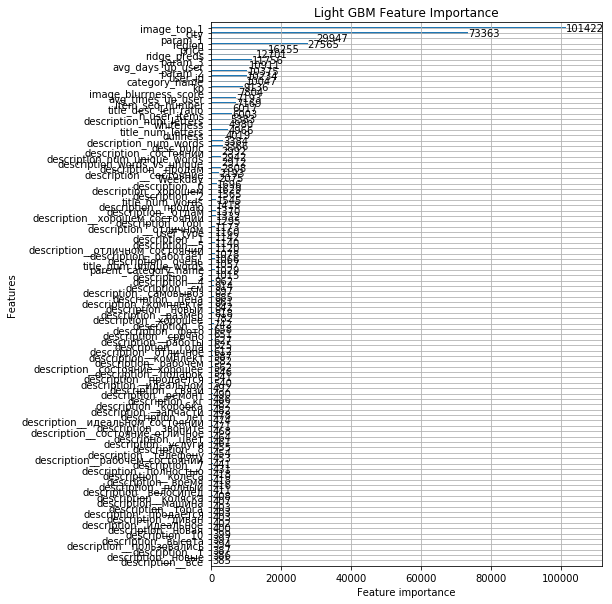

In [13]:

# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)

from sklearn.metrics import mean_squared_error
from math import sqrt

ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}

#Ridge oof method from Faron's kernel
#I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
#It doesn't really add much to the score, but it does help lightgbm converge faster
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])

rms = sqrt(mean_squared_error(y, ridge_oof_train))
print('Ridge OOF RMSE: {}'.format(rms))

print("Modeling Stage")

ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])

df['ridge_preds'] = ridge_preds

# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

print("\nModeling Stage")

del ridge_preds,vectorizer,ready_df
gc.collect();
    
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 500,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.0175,
    'verbose': 0
}  

VALID = False
if VALID == True:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.10, random_state=2018)
        
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X, X_train; gc.collect()

    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=20000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
    del X_valid ; gc.collect()

else:
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X, y,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X; gc.collect()
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=1448,
        verbose_eval=100
    )



# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=100, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

print("Model Evaluation Stage")
lgpred = lgb_clf.predict(testing) 

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)


In [14]:
lgsub['deal_probability'] = lgsub['deal_probability'].clip(0.0, 1.0) # Between 0 and 1
lgsub.to_csv("submission_file.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 68.49 Minutes


Text(0.5,1,'Light GBM Feature Importance')

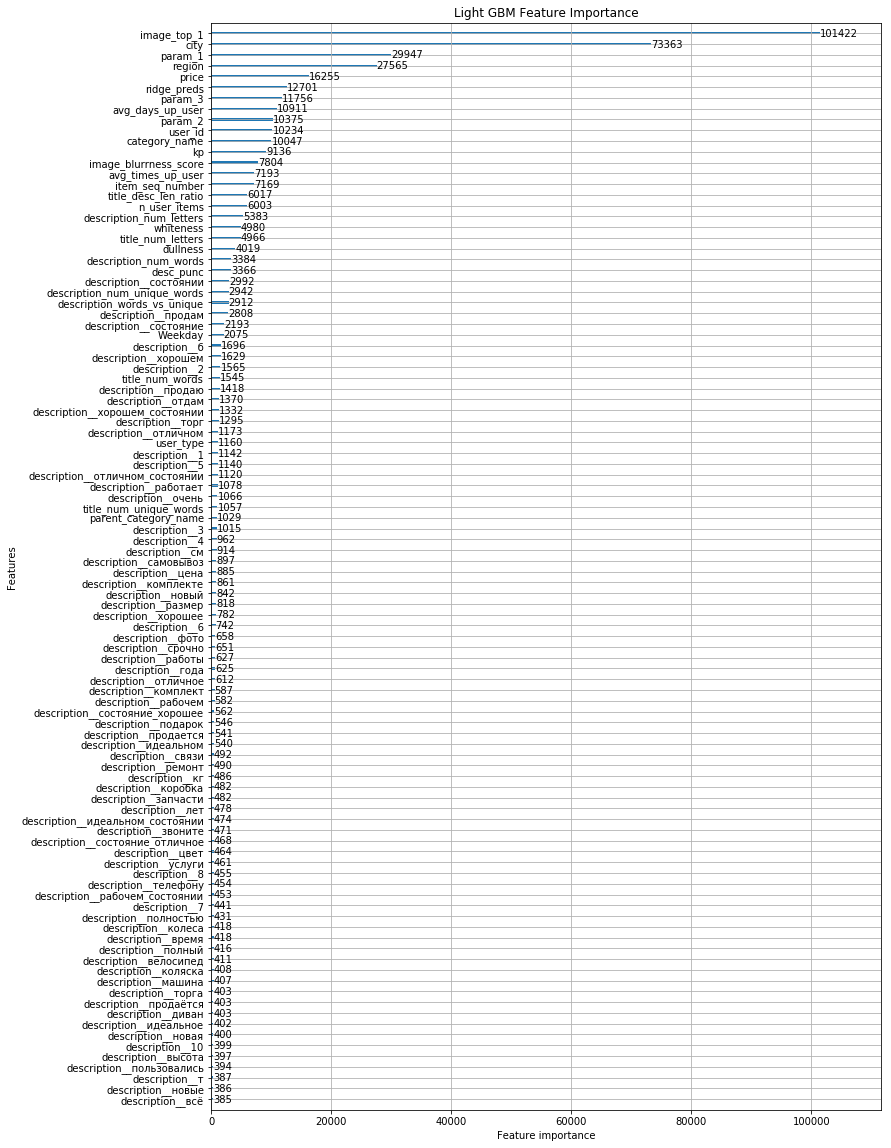

In [15]:
f, ax = plt.subplots(figsize=[12,20])
lgb.plot_importance(lgb_clf, max_num_features=100, ax=ax)
plt.title("Light GBM Feature Importance")